## Notebook 2: Segmentation of satellite images of water bodies using pretrained Resnet-50 model in Pytorch

The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I applied the pretrained DeepLabV3 ResNet-50 model in Pytorch to perform segmentation on the water body images. I chose the DeepLabV3 semantic segmentation architecture because of its effectiveness and simplicity.

**1. Prepare Problem**

In [1]:
# a) Load libraries
import os
import glob
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import cv2
!pip install imagehash
import imagehash

import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

from sklearn.model_selection import train_test_split
from PIL import Image

from pickle import dump

# Check if GPU parallel computing is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [2]:
# b) Prepare dataset
# Here I selected large images height and width to improve training performance
height = width = 500 
batch = 11

images_list = sorted(glob.glob("/Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/*.jpg"))
masks_list = sorted(glob.glob("/Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Masks/*.jpg"))

print(len(images_list), len(masks_list))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

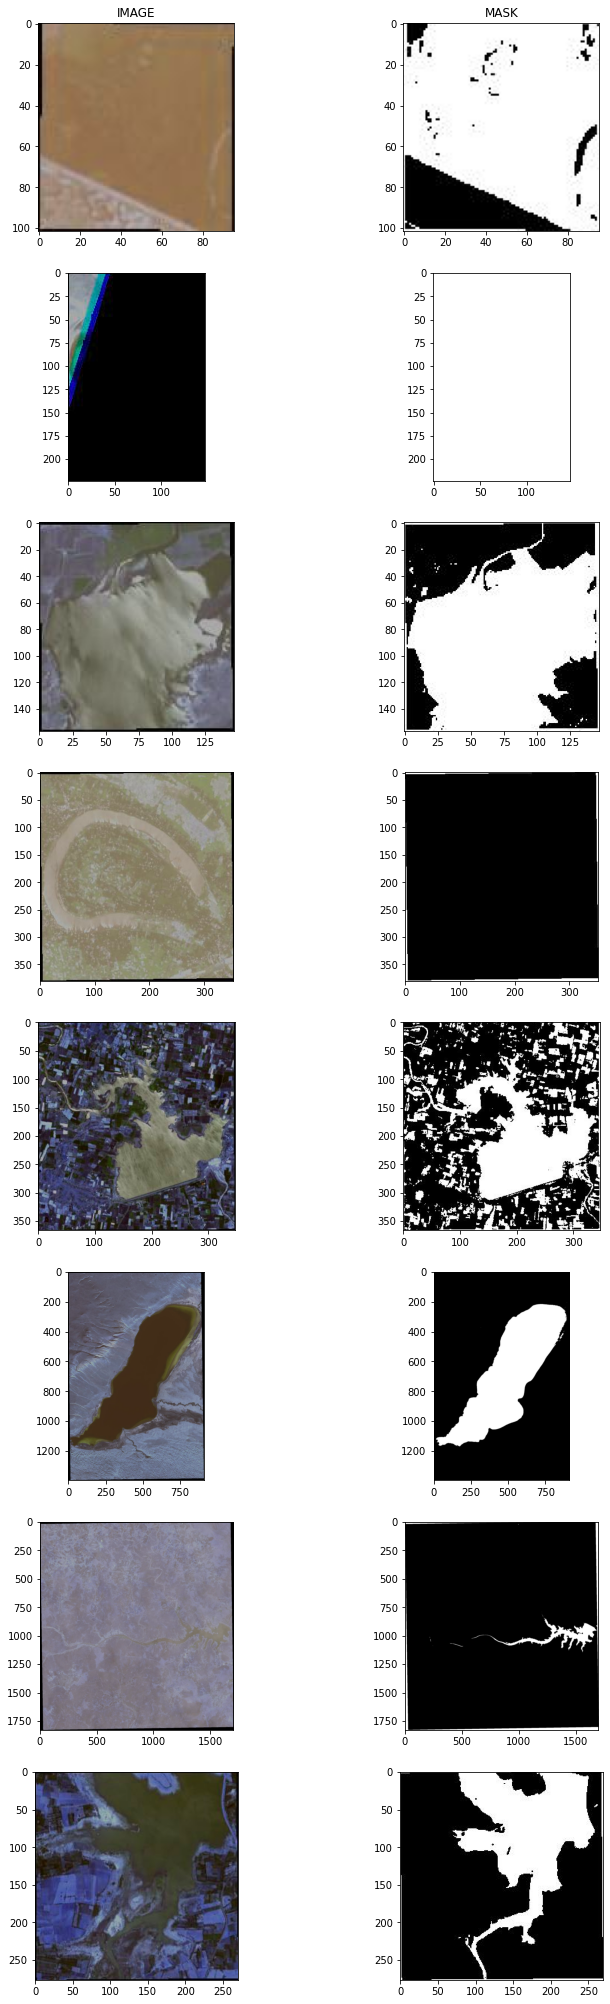

In [3]:
# a) Image visualization
# plot first few images in Images and Masks folder 
f, axr = plt.subplots(8, 2, figsize=(12, 36)) 
for i in range(8):
    idx = np.random.randint(0, len(images_list))
    original = cv2.imread(images_list[idx])
    mask = cv2.imread(masks_list[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask, cmap = 'gray')
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different shapes and even blank masks. These factors may present challenges during the transformation and training processes.

Let's examine the statistical figures of the dataset to understand how the dimensions are distributed among the images. This will help us identify any abnormal size images that can be filtered out to improve training performance.

In [4]:
# Calculate statistics of the image dimensions
dimen_img_list = []

for img in images_list:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)   

In [5]:
# Calculate statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 445.2555438225977
Median width: 259.0
Standard deviation of width: 553.6202774845702
Minimum height: 7
Maximum height: 7093
Mean height: 560.6652587117212
Median height: 334.0
Standard deviation of height: 688.890393959364


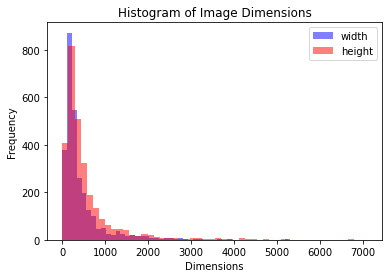

In [6]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

The statistical result suggests that the median values of height and width of the images are around 300 pixels and therefore, it would be advisable to resize all images and masks to this size or larger to ensure good training performance. To filter out any images with abnormal sizes, a cut-off threshold of 32 pixels (which is 10% of the median value) will be applied.

**3. Prepare Data**

In [7]:
# a) Data Cleaning

#Detect duplicate images and masks
hashes = {}
to_remove = []

for file in images_list:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            
            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("/Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Masks", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file


Duplicate image found: /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1244.jpg and /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1333.jpg and /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1552.jpg and /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1619.jpg and /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1659.jpg and /Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sanya

After removing 17 duplicate images and their corresponding masks, new lists of images and masks were created for the next stage of data processing.

In [8]:
# Create a new list of filenames that excludes the duplicates
new_images_list = [file for file in images_list if file not in to_remove]
new_masks_list = [os.path.join("/Users/sanyamchaudhary/Downloads/Water Bodies Dataset 2/Masks", os.path.basename(file)) for file in new_images_list]
print(len(new_images_list), len(new_masks_list))

2824 2824


In [12]:
import cv2
import numpy as np

min_size = 32
df_images = []
df_masks = []

for img, mask in zip(new_images_list, new_masks_list):
    # Load images in RGB and grayscale
    n = cv2.imread(img, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image and mask exist and meet the size and content criteria
    if n is not None and m is not None and min(n.shape[:2]) > min_size and ((m != 0).any() or (m != 255).any()):
        # Resize images and masks to a consistent shape (e.g., 256x256)
        n = cv2.resize(n, (256, 256))  # Use desired dimensions
        m = cv2.resize(m, (256, 256))  # Use the same dimensions

        df_images.append(n)
        df_masks.append(m)

# Convert lists of images and masks to NumPy arrays
df_images = np.array(df_images)
df_masks = np.array(df_masks)

print(len(df_images), len(df_masks))


2803 2803


In total, 126 images and their corresponding masks were removed from the dataset, leaving a total of 2698 samples for training, testing, and validation.

In [13]:
# Create a preprocessing pipeline for images and masks
tfImg = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
tfMsk = tf.Compose([
        tf.ToPILImage(),
        tf.Resize((height, width)),
        tf.ToTensor(),
        ])

In [14]:
# Create a function to read images and masks randomly
def ReadImage(df_images, df_masks):
    idx = np.random.randint(0, len(df_images))
    Img = tfImg(df_images[idx])
    Msk = tfMsk(df_masks[idx])
    return Img, Msk

In [15]:
# Create a function to load images and masks in batch
def LoadBatch(df_images, df_masks):
    images = torch.zeros([batch, 3, height, width])
    masks = torch.zeros([batch, height, width])
    for i in range(batch):
        images[i], masks[i] = ReadImage(df_images, df_masks)
    return images, masks

In [16]:
# a) Split data into train, test and validation sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2102, 256, 256, 3) (2102, 256, 256) (690, 256, 256, 3) (690, 256, 256) (11, 256, 256, 3) (11, 256, 256)


**4. Evaluate Models**

In [17]:
# a) Define pretrained ResNet-50 model using TorchVision DeepLabV3 architecture
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained = True)

# Since the segmented images have 2 classes (black and white), we change the final layer to 2 classes
model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size = (1, 1), stride = (1, 1)) 
model = model.to(device)

# Select Stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 (optimum for image segmentation)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /Users/sanyamchaudhary/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:08<00:00, 18.8MB/s] 


In [18]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss() 
Losses = []

In [21]:
# b) Evaluation of train dataset
epochs = 12

# Training loop
for itr in range(epochs):
   images, masks = LoadBatch(X_train, y_train)
   # Load images and masks tensors to the GPU 
   images = torch.autograd.Variable(images,requires_grad = False).to(device) 
   masks = torch.autograd.Variable(masks, requires_grad = False).to(device) 
   
   # Forward training loop
   Pred = model(images)['out']
   model.zero_grad()
   Loss = criterion(Pred, masks.long())
   Losses.append(Loss.item())

   # Backward training loop
   Loss.backward() 
   optimizer.step() # Apply gradient descent to optimize weights
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss.data.cpu().numpy())

KeyboardInterrupt: 

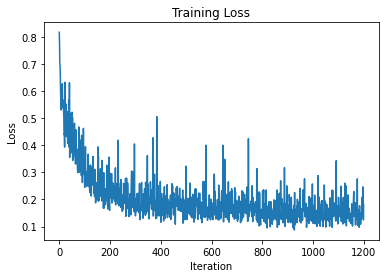

In [17]:
# Plot the training loss values
plt.plot(Losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

The results of training the model show that the loss values were slightly better than the TensorFlow model (0.12 vs. 0.34). It seems that the optimal number of epochs for achieving good loss values is around 1000, and increasing the number of epochs beyond this point does not significantly improve training performance. 

Now that the model has been trained, we can proceed to testing it with new images.

In [18]:
# Set trained model to the evaluation mode for validation test set
model.eval() 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [19]:
Losses_test = []

with torch.no_grad(): # Set context to not calculate and save gradients
  correct = 0
  total = 0
  for itr in range(epochs):
   images_test, masks_test = LoadBatch(X_test, y_test)
   # Load images and masks tensors to the GPU 
   images_test = torch.autograd.Variable(images_test,requires_grad = False).to(device) 
   masks_test = torch.autograd.Variable(masks_test, requires_grad = False).to(device) 
   
   Pred_test = model(images_test)['out']
   model.zero_grad()
   Loss_test = criterion(Pred_test, masks_test.long())
   Losses_test.append(Loss_test.item())

   seg = torch.argmax(Pred_test[0], 0).cpu().detach().numpy() # Move the tensor to the CPU, detach it from the graph, and convert it to a NumPy array
   print(itr,") Loss=", Loss_test.data.cpu().numpy())

0 ) Loss= 0.095648296
1 ) Loss= 0.13649268
2 ) Loss= 0.13199876
3 ) Loss= 0.25829047
4 ) Loss= 0.17824657
5 ) Loss= 0.13677922
6 ) Loss= 0.11178189
7 ) Loss= 0.17092529
8 ) Loss= 0.20780078
9 ) Loss= 0.25595328
10 ) Loss= 0.13804024
11 ) Loss= 0.15090401
12 ) Loss= 0.20150757
13 ) Loss= 0.172735
14 ) Loss= 0.29121822
15 ) Loss= 0.15871935
16 ) Loss= 0.119072475
17 ) Loss= 0.20315039
18 ) Loss= 0.19139105
19 ) Loss= 0.23611191
20 ) Loss= 0.15282537
21 ) Loss= 0.10399962
22 ) Loss= 0.19910255
23 ) Loss= 0.2537424
24 ) Loss= 0.19644424
25 ) Loss= 0.16353048
26 ) Loss= 0.10688399
27 ) Loss= 0.12752703
28 ) Loss= 0.18356782
29 ) Loss= 0.18573019
30 ) Loss= 0.21300615
31 ) Loss= 0.17061459
32 ) Loss= 0.11459651
33 ) Loss= 0.22892077
34 ) Loss= 0.19667068
35 ) Loss= 0.16010255
36 ) Loss= 0.17263205
37 ) Loss= 0.18679963
38 ) Loss= 0.1807213
39 ) Loss= 0.16669741
40 ) Loss= 0.16900209
41 ) Loss= 0.15348096
42 ) Loss= 0.12355562
43 ) Loss= 0.14870812
44 ) Loss= 0.18537022
45 ) Loss= 0.14584963


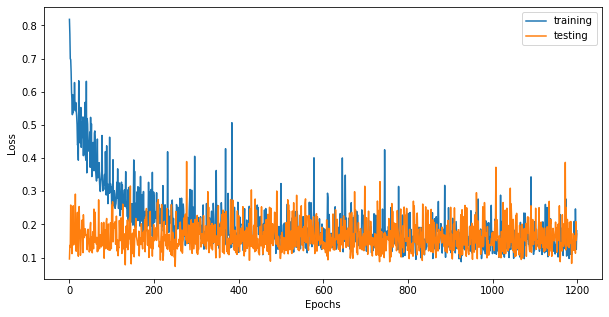

In [20]:
# Plot the training loss values
plt.figure(figsize = (10, 5))
plt.plot(Losses, label = 'training')
plt.plot(Losses_test, label = 'testing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The consistency between the training and validation losses suggests that the model is capable of accurately predicting on new data.

**5. Finalize Model**

In [21]:
# a) Predictions on new images and masks 
# Set trained model to the evaluation mode
model.eval() 

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [22]:
# a) Predictions on validation data
Pred_val = []
with torch.no_grad(): # Set context to not calculate and save gradients
    for i in X_val:
        Img_tensor = tfImg(i)
        # Load tensor images to GPU    
        Img_tensor = torch.autograd.Variable(Img_tensor, requires_grad = False).to(device).unsqueeze(0)
        Pred2 = model(Img_tensor)['out']
        Pred_val.append(Pred2)

In [23]:
pred_np_list = []
for i in range(len(Pred_val)):
    #Get original shape of images in X_val
    height_orgin, width_orgin, d = X_val[i].shape 
    pred_tensor = Pred_val[i]
    # Resize segmented images to origninal sizes
    pred_resized = tf.Resize((height_orgin,width_orgin))(pred_tensor[0]) 
    #Convert the tensor image to a numpy array
    pred_np = pred_resized.cpu().detach().numpy()
    pred_np_list.append(pred_np)

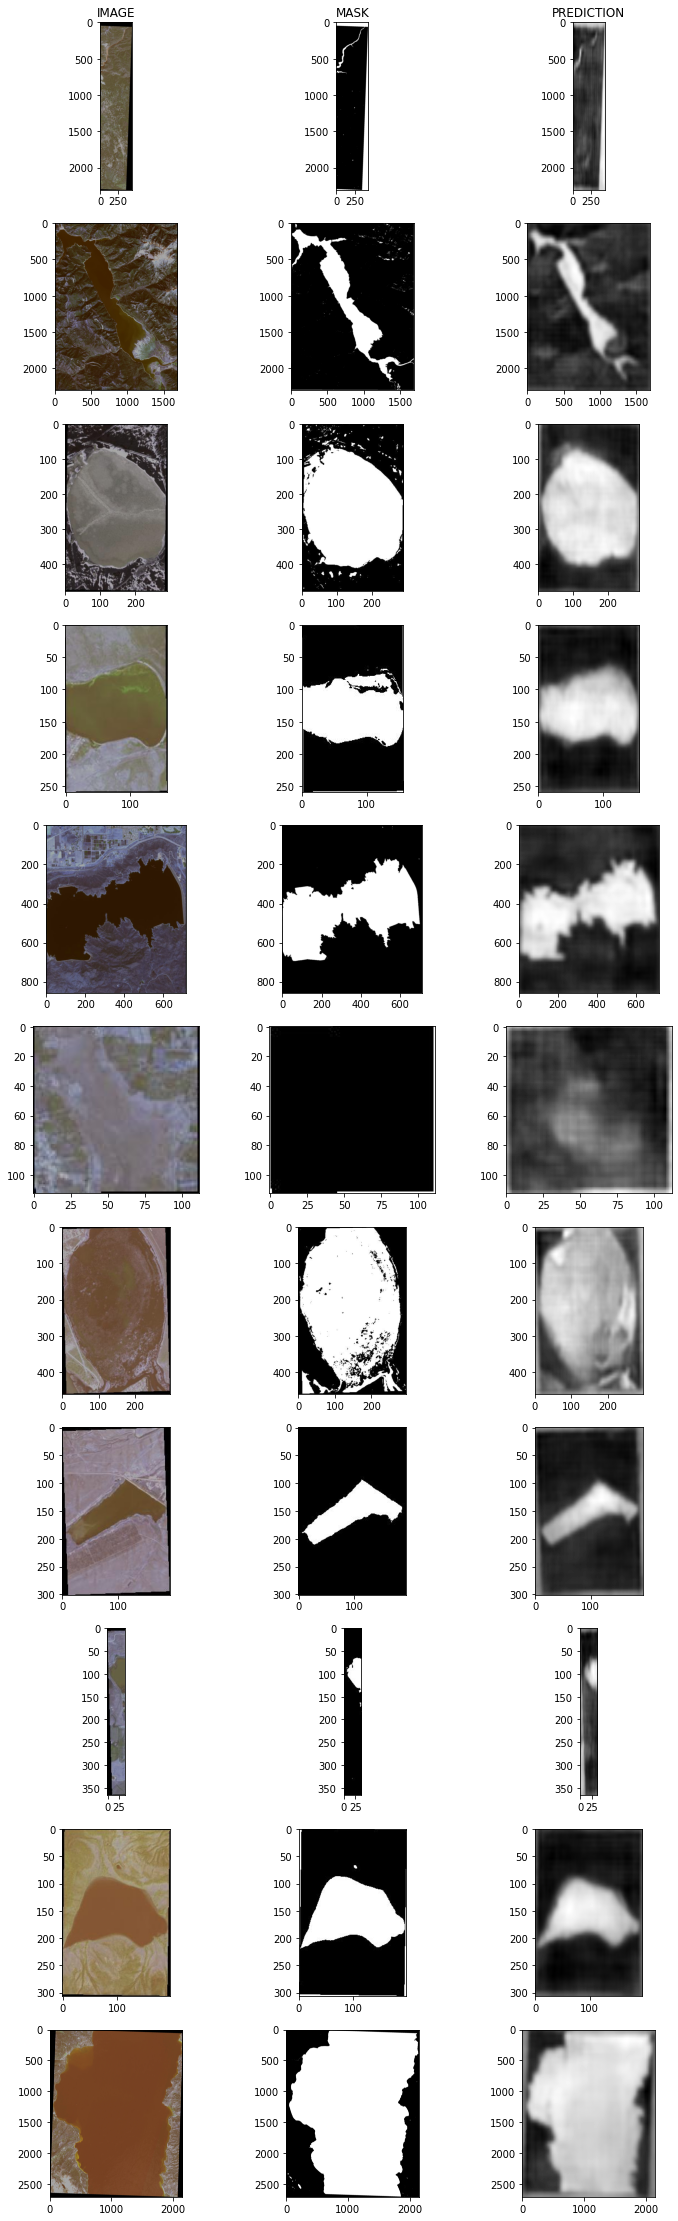

In [24]:
# Plot original and predicted images
fig, ax = plt.subplots(len(X_val), 3, figsize=(12,40))
for i in range(len(X_val)):
    orig = X_val[i]
    msk = y_val[i]
    seg = pred_np_list[i][1, :, :]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(seg, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

The trained model appears to be effective at performing segmentation on new images that it was not trained on.

In [25]:
# b) Save the model for later use
# save the best model's weights to a file for future inference
torch.save(model.state_dict(), "best_model.pth")

**6. Conclusions**

- Data cleaning is essential to remove duplicate, blank and abnormal size images.

- Increasing the size of the images, batch size, the number of epochs and size of dataset can enhance the performance of the training process.

- The DeepLabV3 architecture is a simple and highly effective pretrained model for semantic segmentation in pytorch.

- When comparing the validation loss of the pretrained Resnet-50 model in Pytorch to that of the Keras model (0.12 vs. 0.34), we can see the computational demands of the DeepLabV3 model are significantly higher but its prediction accuracy is about the same as the Keras model.